# <center>Итоговый проект: Fashion-MNIST

Fashion-MNIST – это датасет состоящий из 70000 черно-белых изображений одежды 28х28 пикселей каждое. 60000 из них содержатся в тренировочной выборке, и 10000 – в тестовой. Этот набор данных представляет из себя альтернативу обычному датасету рукописных цифр MNIST. Существовало несколько предпосылок для создания такого набора данных.

Большинство исследователей в области машинного и глубинного обучения используют MNIST при первой проверки своих моделей, что не всегда является хорошей идеей. Если какая-то модель не работает на датасете MNIST – это не значит, что она не работает в принципе. Если какая-то модель прекрасно работает на датасете MNIST – это не означает, что она так же хорошо будет работать на других датасетах. Известны случаи в отказе публикации некоторых статей из-за недостаточно хорошего качества модели на MNIST. Поэтому Zalando Research предложили альтернативу.

В Fashion-MNIST содержится 10 классов разной одежды по аналогии с 10 цифрами из MNIST. Скачать датасет и найти его подробное описание можно найти здесь

- [Fashion-MNIST](https://www.kaggle.com/zalando-research/fashionmnist)

In [21]:
import os
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

In [207]:
plt.style.use('ggplot')

In [2]:
path_to_data = "data"

### Загрузка данных

In [3]:
data_test = pd.read_csv(os.path.join(path_to_data, "fashion-mnist_test.csv"))
data_test.shape

(10000, 785)

In [4]:
data_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data_train = pd.read_csv(os.path.join(path_to_data, "fashion-mnist_train.csv"))
data_train.shape

(60000, 785)

В данном случае, количество признаков равно 28x28=784, так же мы имеем 60000 объектов в тренировочной выборке.

### посмотрим на силуэты, с которыми будем работать

In [81]:
def picture_show(data, num, ax=plt):
    picture = data.drop("label", axis=1).values[num].reshape((28, 28))
    ax.imshow(picture, cmap=plt.cm.binary);

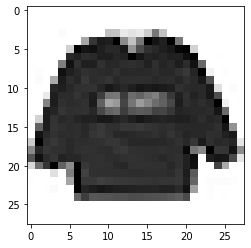

In [82]:
picture_show(data_train, 0)

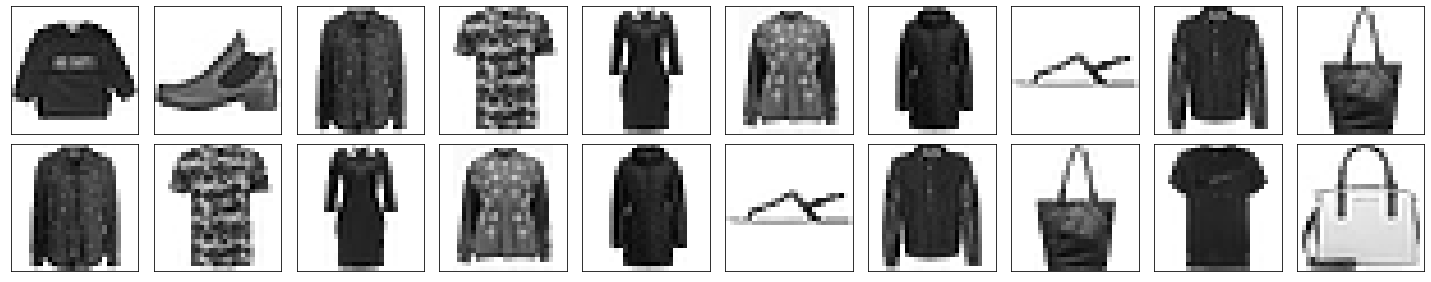

In [90]:
nrows, ncols = 2, 10
fig, ax = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
for row in range(nrows):
    for col in range(ncols):
        num = row * nrows + col
        picture_show(data_train, num, ax[row, col])
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
plt.tight_layout()

### Подготовим данные

In [16]:
def get_x_y(data, num_classes=10):
    x = data.drop("label", axis=1).values.reshape(-1, 784).astype("float32") / 255
    y = tf.keras.utils.to_categorical(data["label"].values, num_classes)
    return x, y

In [18]:
num_classes = 10 

x_train, y_train = get_x_y(data_train, num_classes)
x_test, y_test = get_x_y(data_test, num_classes)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

## 1. Логистическая регрессия

Для решения задачи классификации предлагается начать с использования логистической регрессии. В данном случае, количество признаков равно 28x28=784, так же мы имеем 60000 объектов в тренировочной выборке. Рекомендуется использовать **tensorflow** или **keras** для выполнения этого задания. Используйте стохастический градиентный спуск (**stochastic gradient descent**) в качестве алгоритма оптимизации.

По своей сути, логистическая регрессия может быть реализована как нейронная сеть без скрытых слоев. В выходном слое содержится количество нейронов, равное количеству классов. В качестве функции активации выходного слоя следует использовать **softmax**.

Обучите логистическую регрессию на тренировочной выборке и оцените качество на тестовой выборке используя метрику **accuracy**. Постройте график качества модели на валидационной выборке от количества эпох. Для этого вы можете использовать утилиту **tensorboard**
- [tensorboard в tensorflow](https://www.tensorflow.org/guide/summaries_and_tensorboard)
- [tensorboard в keras](https://keras.io/callbacks/#tensorboard)

In [111]:
def create_model():
    model = tf.keras.models.Sequential() 
    model.add(tf.keras.layers.Dense(num_classes, input_shape=(784,), activation="softmax"))

    model.compile(
        loss="categorical_crossentropy", 
        optimizer="sgd", 
        metrics=["accuracy"]
    )
    return model

In [112]:
model = create_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [191]:
class AccuracyHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.accuracy = []
        self.val_accuracy = []

    def on_epoch_end (self, epoch, logs={}):
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        

In [192]:
history = AccuracyHistory()
model.fit(x_train, y_train, epochs=20, validation_freq=1, verbose=1,  validation_data=(x_test, y_test), callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 43us/sample - loss: 0.3784 - accuracy: 0.8700 - val_loss: 0.4168 - val_accuracy: 0.8553
Epoch 2/20
60000/60000 [==============================] - 3s 43us/sample - loss: 0.3782 - accuracy: 0.8692 - val_loss: 0.4154 - val_accuracy: 0.8592
Epoch 3/20
60000/60000 [==============================] - 3s 43us/sample - loss: 0.3782 - accuracy: 0.8691 - val_loss: 0.4161 - val_accuracy: 0.8596
Epoch 4/20
60000/60000 [==============================] - 3s 43us/sample - loss: 0.3781 - accuracy: 0.8686 - val_loss: 0.4148 - val_accuracy: 0.8583
Epoch 5/20
60000/60000 [==============================] - 3s 42us/sample - loss: 0.3779 - accuracy: 0.8687 - val_loss: 0.4169 - val_accuracy: 0.8571
Epoch 6/20
60000/60000 [==============================] - 3s 43us/sample - loss: 0.3780 - accuracy: 0.8690 - val_loss: 0.4155 - val_accuracy: 0.8585
Epoch 7/20
60000/60000 [==============================] 

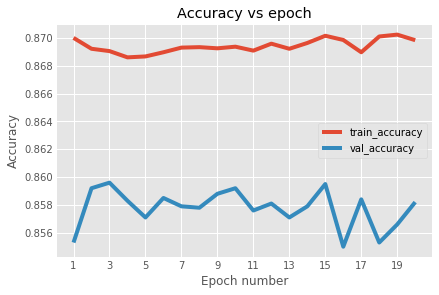

In [209]:
plt.plot(range(1, 21), history.accuracy, label="train_accuracy")
plt.plot(range(1, 21), history.val_accuracy, label="val_accuracy")
plt.legend()
plt.xticks(range(1, 21, 2))
plt.title("Accuracy vs epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch number");

In [204]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0) 
print("Test loss:", loss) 
print("Test accuracy:", accuracy)

Test loss: 0.41626551425457003
Test accuracy: 0.8582


## 2. Полносвязная нейронная сеть

Реализовать полносвязную нейронную сеть с несколькими скрытыми слоями. Обучить модель и посчитать качество на тестовой выборке. Как оно изменилось в сравнении с логистической регрессией? Как вы можете объяснить этот результат?

In [214]:
def create_model():
    model = tf.keras.models.Sequential() 
    model.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(784,))) 
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy", 
        optimizer="sgd", 
        metrics=["accuracy"]
    )
    return model

In [215]:
model = create_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


In [216]:
history = AccuracyHistory()
model.fit(x_train, y_train, epochs=20, validation_freq=1, verbose=1,  validation_data=(x_test, y_test), callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 82us/sample - loss: 0.7110 - accuracy: 0.7670 - val_loss: 0.5158 - val_accuracy: 0.8249
Epoch 2/20
60000/60000 [==============================] - 5s 78us/sample - loss: 0.4881 - accuracy: 0.8299 - val_loss: 0.4545 - val_accuracy: 0.8430
Epoch 3/20
60000/60000 [==============================] - 5s 79us/sample - loss: 0.4434 - accuracy: 0.8445 - val_loss: 0.4479 - val_accuracy: 0.8425
Epoch 4/20
60000/60000 [==============================] - 5s 77us/sample - loss: 0.4162 - accuracy: 0.8536 - val_loss: 0.4088 - val_accuracy: 0.8596
Epoch 5/20
60000/60000 [==============================] - 5s 87us/sample - loss: 0.3961 - accuracy: 0.8599 - val_loss: 0.3987 - val_accuracy: 0.8607
Epoch 6/20
60000/60000 [==============================] - 6s 93us/sample - loss: 0.3795 - accuracy: 0.8671 - val_loss: 0.3792 - val_accuracy: 0.8692
Epoch 7/20
60000/60000 [==============================] 

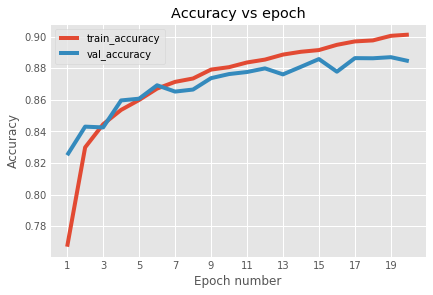

In [218]:
plt.plot(range(1, 21), history.accuracy, label="train_accuracy")
plt.plot(range(1, 21), history.val_accuracy, label="val_accuracy")
plt.legend()
plt.xticks(range(1, 21, 2))
plt.title("Accuracy vs epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch number");

In [217]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0) 
print("Test loss:", loss) 
print("Test accuracy:", accuracy)

Test loss: 0.31598590977191926
Test accuracy: 0.8845


#### Анализ:    
Качество по **accuracy** на тестовой выборке выросло. Кривая обучения более гладкая. Объяснить можно наличием скрытых слоев с нелинейными функциями активации

## 3. Сверточная нейронная сеть

Реализовать сверточную нейронную сеть. В данном случае лучше использовать готовые слои, которые предоставляют **keras** или **tensorflow**.

#### подготовим данные (переформатируем под сверточные сети)

In [223]:
x_train = x_train.reshape(-1, 28, 28, 1) 
x_test = x_test.reshape(-1, 28, 28, 1)

Начните с модели с несколькими сверточными слоями. Так же рекомендуется использовать слои суб-дискретизации, например **Max Pooling** слои. Они понижают размерность сходных данных и выделяют наиболее важные признаки из данных. Посчитайте качество получившейся модели на тестовой выборке. Сравните полученные результаты с результатами полносвязной нейронной сети.

In [221]:
def create_model():
    model = tf.keras.models.Sequential() 
    model.add(tf.keras.layers.Convolution2D(filters=32, input_shape=(28, 28, 1), kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy", 
        optimizer="sgd", 
        metrics=["accuracy"]
    )
    return model

In [222]:
model = create_model()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                102464    
_________________________________________________________________
dense_16 (Dense)             (None, 10)              

In [224]:
history = AccuracyHistory()
model.fit(x_train, y_train, epochs=20, validation_freq=1, verbose=1,  validation_data=(x_test, y_test), callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 37s 623us/sample - loss: 0.9316 - accuracy: 0.6615 - val_loss: 0.6117 - val_accuracy: 0.7764
Epoch 2/20
60000/60000 [==============================] - 41s 685us/sample - loss: 0.5603 - accuracy: 0.7885 - val_loss: 0.5106 - val_accuracy: 0.8111
Epoch 3/20
60000/60000 [==============================] - 40s 661us/sample - loss: 0.4840 - accuracy: 0.8234 - val_loss: 0.4490 - val_accuracy: 0.8405
Epoch 4/20
60000/60000 [==============================] - 41s 682us/sample - loss: 0.4382 - accuracy: 0.8411 - val_loss: 0.4216 - val_accuracy: 0.8469
Epoch 5/20
60000/60000 [==============================] - 41s 676us/sample - loss: 0.4060 - accuracy: 0.8544 - val_loss: 0.3908 - val_accuracy: 0.8595
Epoch 6/20
60000/60000 [==============================] - 38s 634us/sample - loss: 0.3840 - accuracy: 0.8616 - val_loss: 0.3694 - val_accuracy: 0.8691
Epoch 7/20
60000/60000 [====================

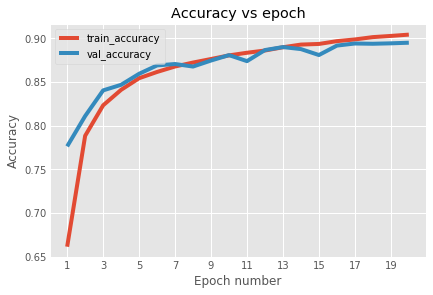

In [225]:
plt.plot(range(1, 21), history.accuracy, label="train_accuracy")
plt.plot(range(1, 21), history.val_accuracy, label="val_accuracy")
plt.legend()
plt.xticks(range(1, 21, 2))
plt.title("Accuracy vs epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch number");

In [226]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0) 
print("Test loss:", loss) 
print("Test accuracy:", accuracy)

Test loss: 0.28685546140670776
Test accuracy: 0.8951


Далее, попробуйте увеличить количество слоев в вашей нейронной сети. Достаточно добавить несколько новых сверточных слоев. Проанализируете, как изменилось качество в этом случае.

Добавим два **Convolution** слоя (без пуллинга, уже маловато разрешения для этого)

In [233]:
def create_model():
    model = tf.keras.models.Sequential() 
    model.add(tf.keras.layers.Convolution2D(filters=32, input_shape=(28, 28, 1), kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy", 
        optimizer="sgd", 
        metrics=["accuracy"]
    )
    return model

In [234]:
model = create_model()
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)              

In [235]:
history = AccuracyHistory()
model.fit(x_train, y_train, epochs=20, validation_freq=1, verbose=1,  validation_data=(x_test, y_test), callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 40s 661us/sample - loss: 1.1376 - accuracy: 0.5725 - val_loss: 0.7482 - val_accuracy: 0.7127
Epoch 2/20
60000/60000 [==============================] - 42s 698us/sample - loss: 0.6471 - accuracy: 0.7549 - val_loss: 0.5770 - val_accuracy: 0.7851
Epoch 3/20
60000/60000 [==============================] - 43s 715us/sample - loss: 0.5432 - accuracy: 0.7978 - val_loss: 0.4805 - val_accuracy: 0.8274
Epoch 4/20
60000/60000 [==============================] - 44s 740us/sample - loss: 0.4843 - accuracy: 0.8195 - val_loss: 0.4471 - val_accuracy: 0.8330
Epoch 5/20
60000/60000 [==============================] - 42s 692us/sample - loss: 0.4420 - accuracy: 0.8371 - val_loss: 0.4106 - val_accuracy: 0.8498
Epoch 6/20
60000/60000 [==============================] - 42s 694us/sample - loss: 0.4083 - accuracy: 0.8503 - val_loss: 0.3954 - val_accuracy: 0.8549
Epoch 7/20
60000/60000 [====================

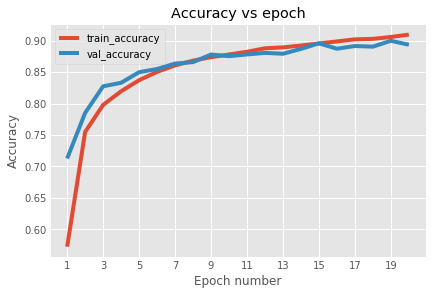

In [236]:
plt.plot(range(1, 21), history.accuracy, label="train_accuracy")
plt.plot(range(1, 21), history.val_accuracy, label="val_accuracy")
plt.legend()
plt.xticks(range(1, 21, 2))
plt.title("Accuracy vs epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch number");

In [237]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0) 
print("Test loss:", loss) 
print("Test accuracy:", accuracy)

Test loss: 0.29134188413619994
Test accuracy: 0.8934


В заключение, рекомендуется попробовать добавить **Batch Normalization** слои. Обычно они располагаются после сверточных слоев или слоев полносвязной нейронной сети. Обычно они улучшают качество модели, этим объясняется их популярность использования в современных архитектурах нейронных сетей. Однако, это требует проверки для конкретной модели и конкретного набора данных.

In [238]:
def create_model():
    model = tf.keras.models.Sequential() 
    model.add(tf.keras.layers.Convolution2D(filters=32, input_shape=(28, 28, 1), kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy", 
        optimizer="sgd", 
        metrics=["accuracy"]
    )
    return model

In [239]:
model = create_model()
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 64)        

In [240]:
history = AccuracyHistory()
model.fit(x_train, y_train, epochs=20, validation_freq=1, verbose=1,  validation_data=(x_test, y_test), callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 57s 949us/sample - loss: 0.4934 - accuracy: 0.8263 - val_loss: 0.4445 - val_accuracy: 0.8363
Epoch 2/20
60000/60000 [==============================] - 55s 910us/sample - loss: 0.3445 - accuracy: 0.8779 - val_loss: 0.3235 - val_accuracy: 0.8854
Epoch 3/20
60000/60000 [==============================] - 53s 888us/sample - loss: 0.3037 - accuracy: 0.8904 - val_loss: 0.2963 - val_accuracy: 0.8934
Epoch 4/20
60000/60000 [==============================] - 53s 876us/sample - loss: 0.2744 - accuracy: 0.9017 - val_loss: 0.2813 - val_accuracy: 0.8984
Epoch 5/20
60000/60000 [==============================] - 54s 907us/sample - loss: 0.2542 - accuracy: 0.9088 - val_loss: 0.2842 - val_accuracy: 0.8964
Epoch 6/20
60000/60000 [==============================] - 53s 876us/sample - loss: 0.2366 - accuracy: 0.9138 - val_loss: 0.2795 - val_accuracy: 0.9005
Epoch 7/20
60000/60000 [====================

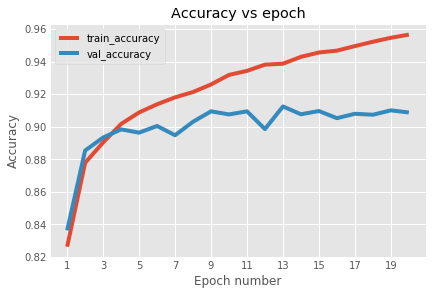

In [241]:
plt.plot(range(1, 21), history.accuracy, label="train_accuracy")
plt.plot(range(1, 21), history.val_accuracy, label="val_accuracy")
plt.legend()
plt.xticks(range(1, 21, 2))
plt.title("Accuracy vs epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch number");

In [242]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0) 
print("Test loss:", loss) 
print("Test accuracy:", accuracy)

Test loss: 0.2844568016797304
Test accuracy: 0.9088


### Выводы:    
Сверточные слои качество сети улучшило.   
Дальнейшее добавление сверточных слоев уже эффекта не дало, видимо - произошло насыщение.    
Добавление батч-нормализации качество улучшило. Хотя, надо отметить, мы увидели сильное переобучение. Возможно, добавление регуляризующих слоев алгоритм может улучшить.